No peaks above 0mV in sweep 0
No peaks above 0mV in sweep 1
Sweep 2:
  Local peak: Voltage=57.68 mV, Time=4.74 s
  Target point: Voltage=-50.69 mV, Time=4.74 s
  Amplitude: 108.37 mV
  Time difference (red - green): 0.55 ms


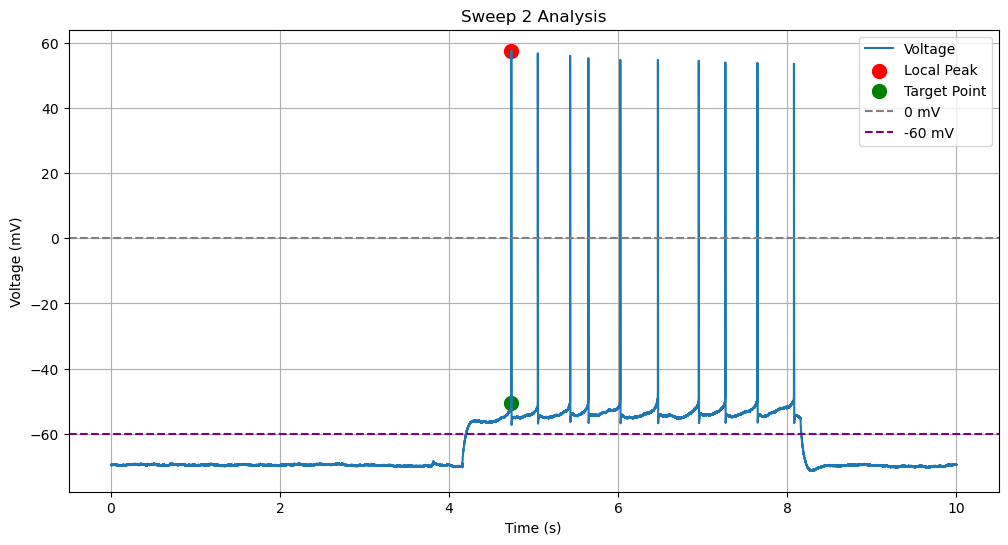

Sweep 3:
  Local peak: Voltage=56.73 mV, Time=4.26 s
  Target point: Voltage=-50.17 mV, Time=4.26 s
  Amplitude: 106.90 mV
  Time difference (red - green): 0.50 ms


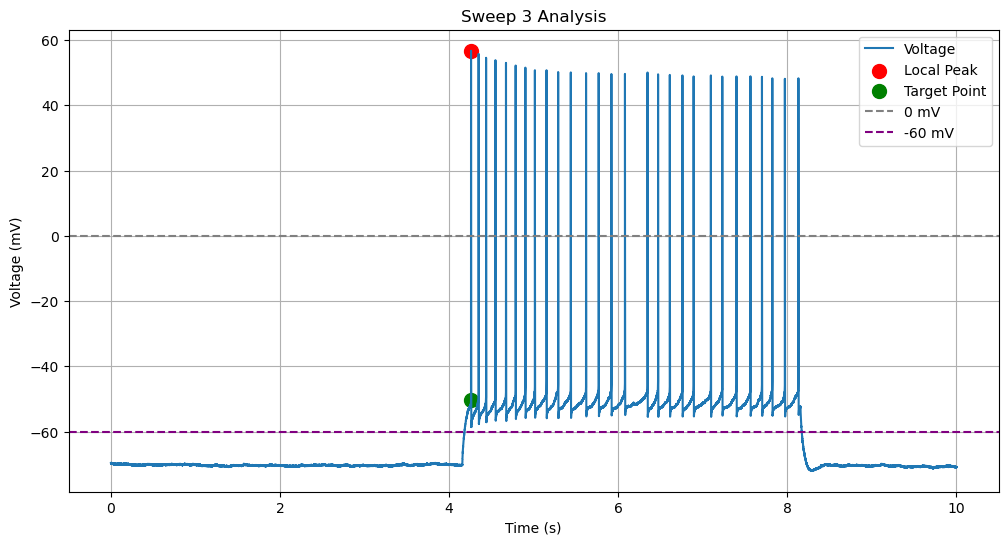

Sweep 4:
  Local peak: Voltage=55.39 mV, Time=4.21 s
  Target point: Voltage=-49.59 mV, Time=4.21 s
  Amplitude: 104.98 mV
  Time difference (red - green): 0.55 ms


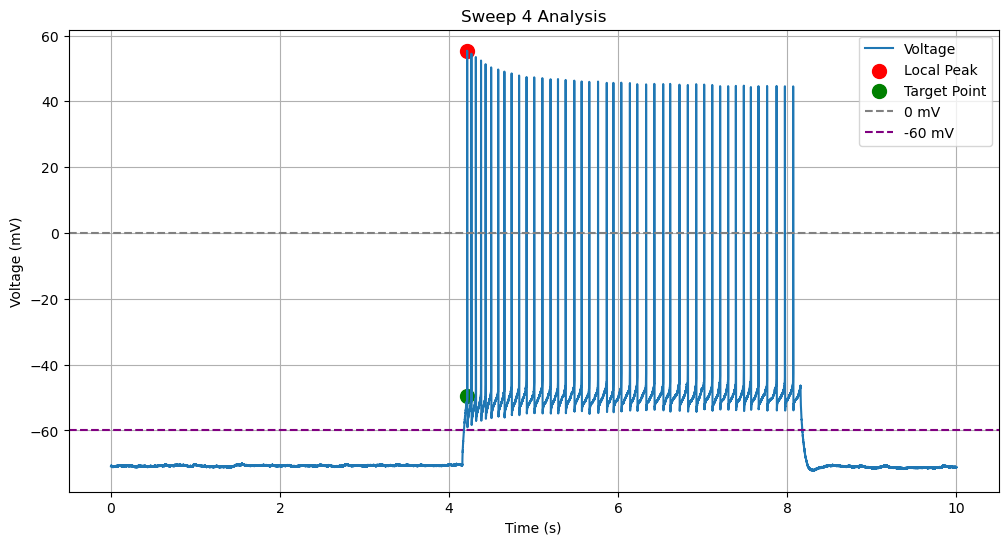

Sweep 5:
  Local peak: Voltage=54.08 mV, Time=4.20 s
  Target point: Voltage=-49.47 mV, Time=4.20 s
  Amplitude: 103.55 mV
  Time difference (red - green): 0.50 ms


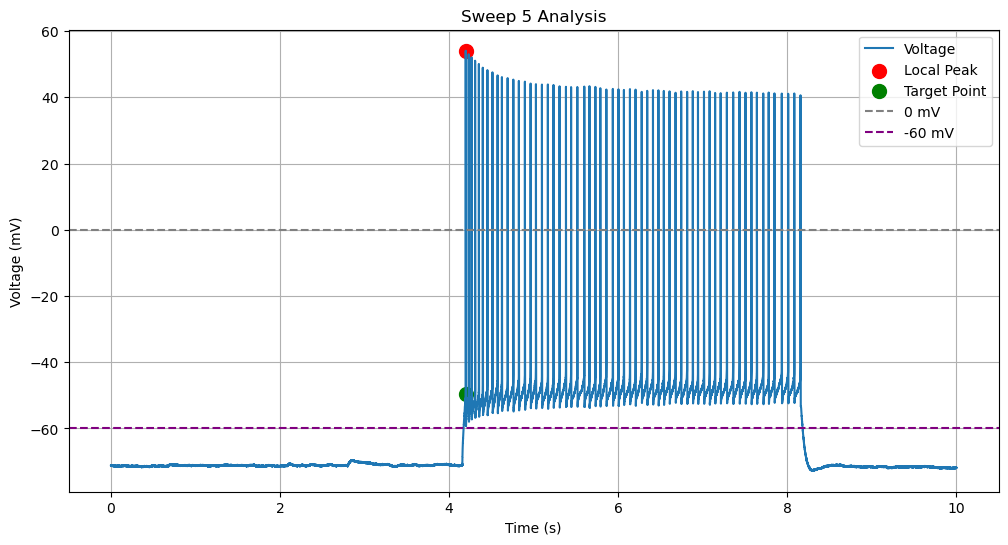

Sweep 6:
  Local peak: Voltage=53.34 mV, Time=4.18 s
  Target point: Voltage=-50.84 mV, Time=4.18 s
  Amplitude: 104.19 mV
  Time difference (red - green): 0.50 ms


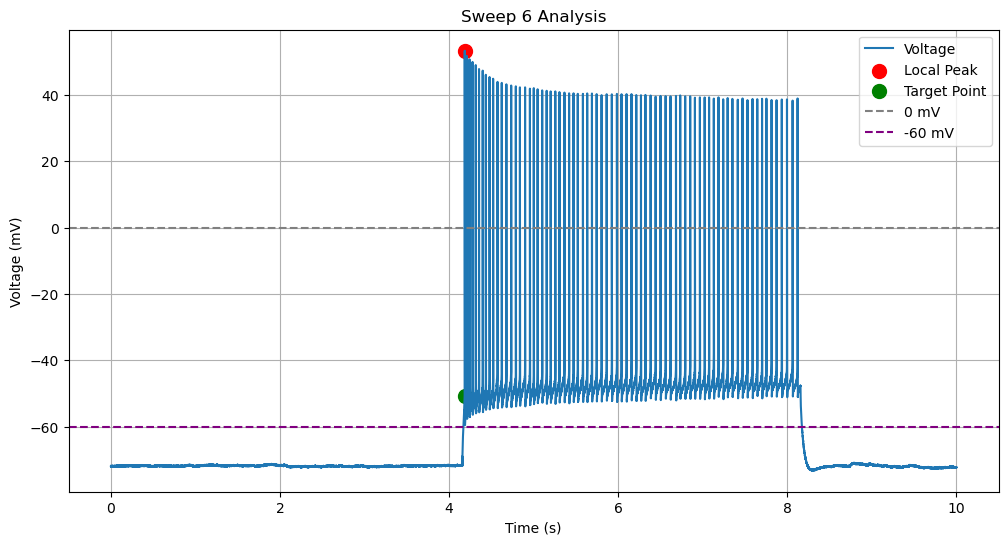

Sweep 7:
  Local peak: Voltage=52.46 mV, Time=4.18 s
  Target point: Voltage=-51.70 mV, Time=4.18 s
  Amplitude: 104.16 mV
  Time difference (red - green): 0.55 ms


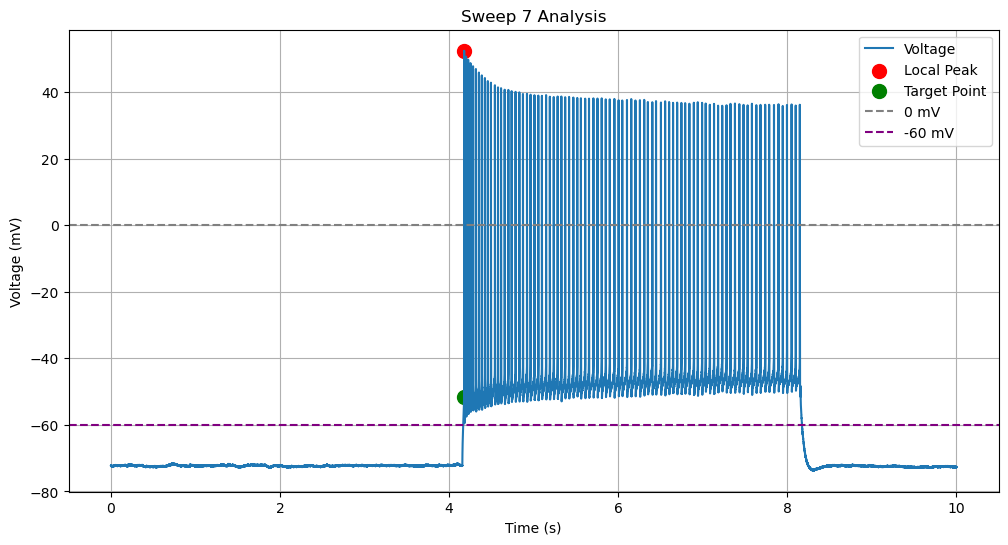

Sweep 8:
  Local peak: Voltage=51.61 mV, Time=4.17 s
  Target point: Voltage=-52.19 mV, Time=4.17 s
  Amplitude: 103.79 mV
  Time difference (red - green): 0.50 ms


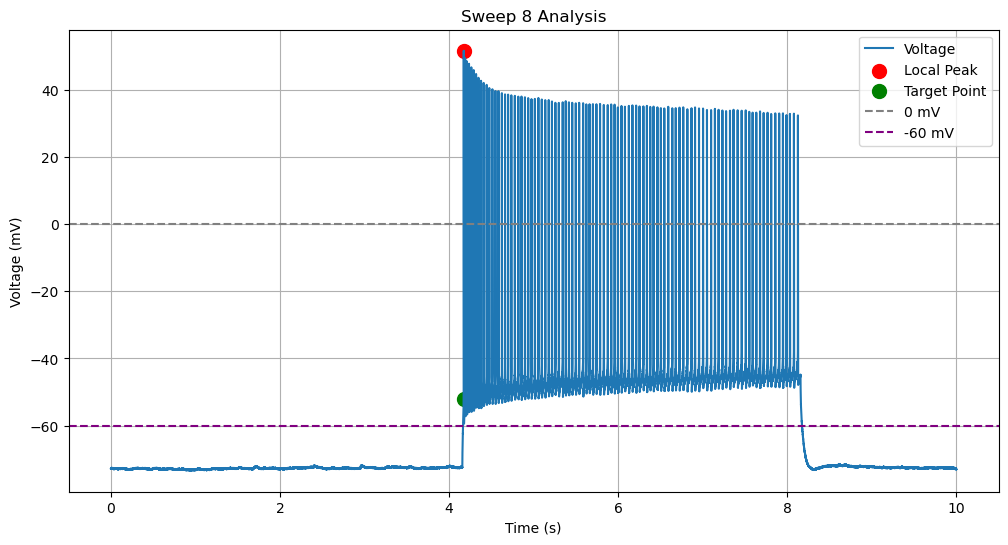

Sweep 9:
  Local peak: Voltage=50.90 mV, Time=4.17 s
  Target point: Voltage=-54.47 mV, Time=4.17 s
  Amplitude: 105.38 mV
  Time difference (red - green): 0.55 ms


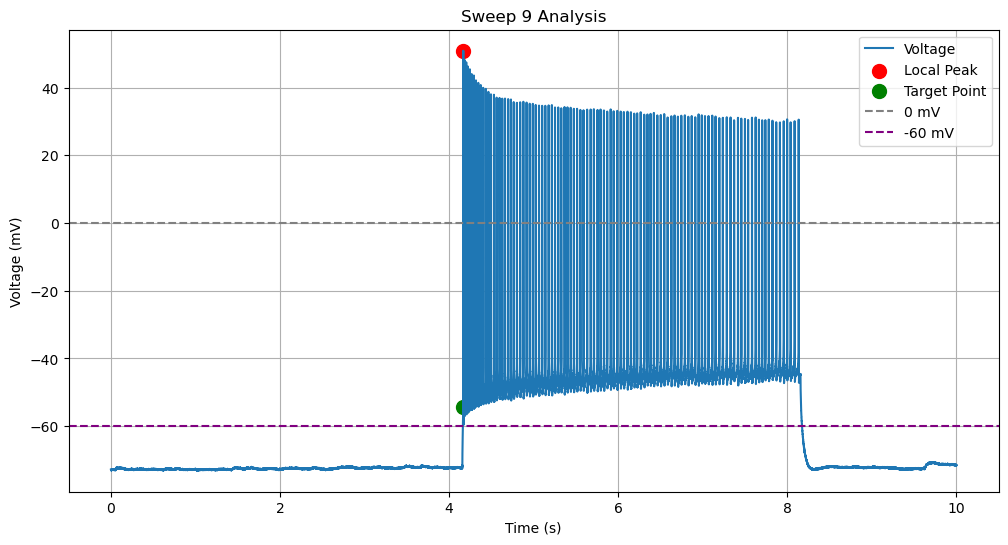

In [117]:
import pyabf
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Define the project path and ABF file name
project_path = 'C:\\Users\\ikmor\\OneDrive\\Documents\\SNR AND OBR pilot study\\'
file_name = 'CNQX1L3 A1.abf'

# Load the ABF file
abf = pyabf.ABF(f'{project_path}{file_name}')

# Function to calculate derivative without skipping datapoints
def calculate_derivative(voltage, times):
    return np.diff(voltage) / np.diff(times)

# Analyze each sweep
sweep_numbers = range(abf.sweepCount)
for sweep in sweep_numbers:
    abf.setSweep(sweep, channel=0)
    voltage = abf.sweepY  # Voltage in mV
    times = abf.sweepX    # Time in seconds

    # 1. Search for the first local peak above 0mV
    peaks, _ = find_peaks(voltage, height=0)
    if len(peaks) == 0:
        print(f"No peaks above 0mV in sweep {sweep}")
        continue  # No peaks above 0mV in this sweep, move to the next one

    first_peak_index = peaks[0]
    first_peak_voltage = voltage[first_peak_index]
    first_peak_time = times[first_peak_index]

    # 2. Calculate derivative of voltage without skipping datapoints
    derivative = calculate_derivative(voltage, times)

    # 3. Find the point that satisfies all conditions
    target_index_28dvdt = None

    for idx in range(max(0, first_peak_index - 50), first_peak_index - 1):
        if derivative[idx] >= 28:
            # Check if the derivative of the next point is at least 10% larger
            if idx + 1 < len(derivative) and derivative[idx + 1] >= 1.1 * derivative[idx]:
                # New condition: Ensure the next 5 points are increasing by at least 0.3 mV
                if all(voltage[i + 1] - voltage[i] >= 0.5 for i in range(idx, min(idx + 5, len(voltage) - 1))):
                    target_index_28dvdt = idx
                    break

    if target_index_28dvdt is None:
        print(f"No point found satisfying all conditions in sweep {sweep}")
        continue

    target_voltage_28dvdt = voltage[target_index_28dvdt]
    target_time_28dvdt = times[target_index_28dvdt]

    # 4. Calculate amplitude between the target point and local peak
    amplitude = first_peak_voltage - target_voltage_28dvdt

    # 5. Calculate time difference between green and red points
    time_difference_ms = (first_peak_time - target_time_28dvdt) * 1000

    # Print results for this sweep
    print(f"Sweep {sweep}:")
    print(f"  Local peak: Voltage={first_peak_voltage:.2f} mV, Time={first_peak_time:.2f} s")
    print(f"  Target point: Voltage={target_voltage_28dvdt:.2f} mV, Time={target_time_28dvdt:.2f} s")
    print(f"  Amplitude: {amplitude:.2f} mV")
    print(f"  Time difference (red - green): {time_difference_ms:.2f} ms")

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(times, voltage, label='Voltage')
    plt.scatter(first_peak_time, first_peak_voltage, color='red', s=100, label='Local Peak')
    plt.scatter(target_time_28dvdt, target_voltage_28dvdt, color='green', s=100, label='Target Point')
    plt.axhline(y=0, color='gray', linestyle='--', label='0 mV')
    plt.axhline(y=-60, color='purple', linestyle='--', label='-60 mV')
    
    plt.title(f'Sweep {sweep} Analysis')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (mV)')
    plt.legend()
    plt.grid(True)
    plt.show()